<a href="https://colab.research.google.com/github/charlesmartin14/theory-paper/blob/main/examples/LSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Applying WeightWatcher to a simple LSA (Latent Semantic Analysis) Calculation

We:

- download and vectorize the 20Newsgroups dataset (just using a CountVectorizer)

- run SVD on the data matrix, keeping the top 5000 components

- apply the weightwatcher powerlaw method, and find $\alpha$ and $x_{min}=\lambda_{min}$

- Compare $\lambda_{min}$ to the explained variance, and 

- the Trace Log Norm $\det\mathbf{X}^{eff}=1$ condition


#### TODO:  redo and triple check detX calcs

In [2]:

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
pd.set_option("display.max_colwidth", 200)

In [3]:
from google.colab import drive
drive.mount('/drive')
results_dir = '/drive/MyDrive/setol_paper'

!ls $results_dir
save = True

Mounted at /drive
alpha_vs_testacc.png  LSA_variance.png	    model_bs16	   model_bs8
bs_vs_testacc.png     MLP3_bs16_FC2.png     model_bs16.h5  model_bs8.h5
bs_vs_trainacc.png    MLP3_bs1_FC2.png	    model_bs1.h5   svd20_vs_testacc.png
LSA_detX.png	      MLP3_bs2_FC2.png	    model_bs2	   svd50_vs_testacc.png
LSA_D_KS.png	      MLP3_bs32_FC2.png     model_bs2.h5   svdP_vs_testacc.png
LSA_evals.png	      MLP3_bs4_FC2.png	    model_bs32	   VIT.png
LSA_local_ratios.png  MLP3_bs8_FC2.png	    model_bs32.h5  VIT_TPL.png
LSA_log_lin_ESD.png   mlp3_results.feather  model_bs4
LSA_PL_fit.png	      model_bs1		    model_bs4.h5


In [4]:
SMALL_SIZE = 10
MEDIUM_SIZE = 16
LARGE_SIZE =30

plt.rc('font', size=LARGE_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title

In [5]:
from pickle import FALSE
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

data, _ = fetch_20newsgroups(
    shuffle=False,
    random_state=1,
    remove=("headers", "footers", "quotes"),
    return_X_y=True,
)


# Use tf-idf features for NMF.
print("Extracting tf-idf features ...")
tfidf_vectorizer = TfidfVectorizer(
   max_df=0.95, min_df=2, max_features=20000, stop_words="english"
)

X  = tfidf_vectorizer.fit_transform(data)
X.shape


Extracting tf-idf features ...


(11314, 20000)

In [6]:
#from sklearn.datasets import fetch_20newsgroups_vectorized
#X, y = fetch_20newsgroups_vectorized(subset='all', return_X_y=True)
#print(X.shape)

### see:
 https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

In [7]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=5000)
svd_model.fit(X)
sv = svd_model.singular_values_
evals = sv*sv


In [8]:
pip install powerlaw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import powerlaw

fit = powerlaw.Fit(evals)
fit.alpha, fit.xmin

Calculating best minimal value for power law fit


(3.5391663725867364, 5.7667863717896495)

### Nunmber of eigenvalues in the fitted PL  tail

In [10]:
start_idx = len(evals[evals >= fit.xmin])
start_idx

240

### WeightWatcher Log-Lin and KS Plots

saving /drive/MyDrive/setol_paper/LSA_log_lin_ESD.png


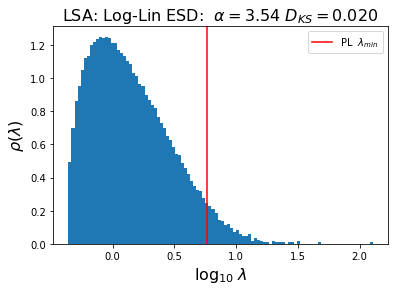

In [11]:
plt.hist(np.log10(evals[evals>0.001]),bins=100, density=True);
plt.axvline(x=np.log10(fit.xmin), color='red', label=r"PL  $\lambda_{min}$")
title =  "LSA: Log-Lin ESD:  "+r"$\alpha=$"+"{:0.2f}".format(fit.alpha) + r" $D_{KS}=$"+"{:0.3f}".format(fit.D)
plt.title(title)
plt.xlabel(r"$\log_{10}\;\lambda$")
plt.ylabel(r"$\rho(\lambda)$")
plt.legend()
if save:
  filename = "LSA_log_lin_ESD.png"
  filename = f"{results_dir}/{filename}"
  print(f"saving {filename}")
  plt.savefig(filename)
plt.show()


saving /drive/MyDrive/setol_paper/LSA_D_KS.png


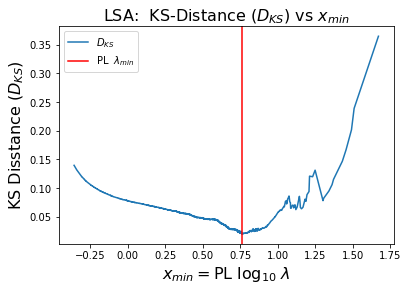

In [12]:
plt.plot(np.log10(fit.xmins), fit.Ds, label=r'$D_{KS}$')
plt.axvline(x=np.log10(fit.xmin), color='red', label=r"PL  $\lambda_{min}$")
plt.ylabel(r'KS Disstance $(D_{KS})$')
plt.xlabel(r'$x_{min}=$PL $\log_{10}\;\lambda$')
plt.title(r"LSA:  KS-Distance $(D_{KS})$ vs $x_{min}$")
plt.legend()
if save:
  filename = "LSA_D_KS.png"
  filename = f"{results_dir}/{filename}"
  print(f"saving {filename}")
  plt.savefig(filename)
plt.show() 

### WeightWatcher Vector Localizations



In [13]:
istart_tail = len(evals[evals>=fit.xmin])
istart_tail

240

In [14]:
def localization_ratio(vec):
    return np.linalg.norm(vec, ord=1) / np.linalg.norm(vec, ord=np.inf)

loc_ratios = [localization_ratio(vec) for vec in svd_model.components_]



saving /drive/MyDrive/setol_paper/LSA_local_ratios.png


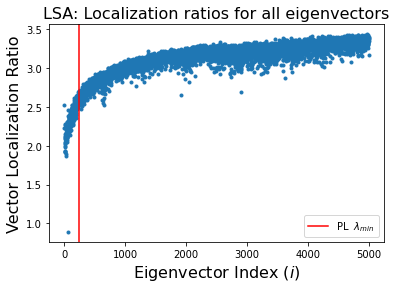

In [15]:
plt.scatter(np.arange(len(loc_ratios)), np.log10(loc_ratios), marker=".", linewidths=1)
plt.axvline(x=istart_tail, color='red', label=r"PL  $\lambda_{min}$")
plt.title("LSA: Localization ratios for all eigenvectors")
plt.xlabel(r"Eigenvector Index $(i)$")
plt.ylabel(r"Vector Localization Ratio")
plt.legend()
if save:
  filename = "LSA_local_ratios.png"
  filename = f"{results_dir}/{filename}"
  print(f"saving {filename}")
  plt.savefig(filename)
              
plt.show()

### Eigenvalues vs fitted PL $\lambda_{min}$

saving /drive/MyDrive/setol_paper/LSA_evals.png


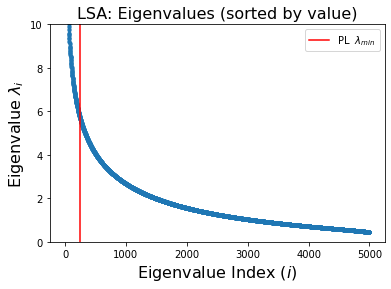

In [16]:
plt.scatter(np.arange(len(loc_ratios)), (evals) , marker='.')
plt.ylim([0,10])
plt.axvline(x=istart_tail, color='red', label=r"PL  $\lambda_{min}$")
plt.xlabel(r"Eigenvalue Index $(i)$")
plt.ylabel(r"Eigenvalue $\lambda_{i}$")
plt.title("LSA: Eigenvalues (sorted by value)")
plt.legend()
if save:
  filename = "LSA_evals.png"
  filename = f"{results_dir}/{filename}"
  print(f"saving {filename}")
  plt.savefig(filename)
plt.show()

### Quality of PL fit on Log-Log Scale, compared to actual data distributions

In [17]:
def plot_logloghist(x, xmin, transparency=0.75):
    hist, bins = np.histogram(x, bins=100)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins, density=True, alpha=transparency)

    if xmin:
        plt.axvline(xmin, color='r', label=r'PL $\lambda_{min}$')

    plt.xscale('log')
    plt.yscale('log')

saving /drive/MyDrive/setol_paper/LSA_PL_fit.png


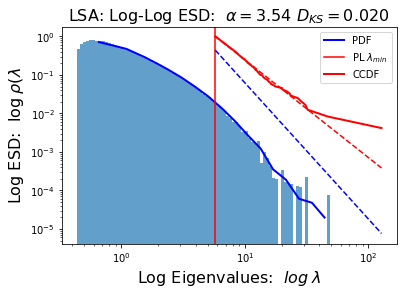

In [18]:
fig2 = fit.plot_pdf(color='b', linewidth=2, original_data=True, label='PDF')
plot_logloghist(evals, fit.xmin,transparency=0.7)

fit.power_law.plot_pdf(color='b', linestyle='--', ax=fig2)
fit.plot_ccdf(color='r', linewidth=2, ax=fig2, label='CCDF')
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=fig2)

title =  "LSA: Log-Log ESD:  "+r"$\alpha=$"+"{:0.2f}".format(fit.alpha) + r" $D_{KS}=$"+"{:0.3f}".format(fit.D)
plt.title(title)
plt.xlabel(r"Log Eigenvalues:  $log\;\lambda$")
plt.ylabel(r"Log ESD:  $\log\;\rho(\lambda}$")
plt.legend()
if save:
  filename = "LSA_PL_fit.png"
  filename = f"{results_dir}/{filename}"
  print(f"saving {filename}")
  plt.savefig(filename)
plt.show()          



### Explained Variance vs fitted PL $\lambda_{min}$

saving /drive/MyDrive/setol_paper/LSA_variance.png


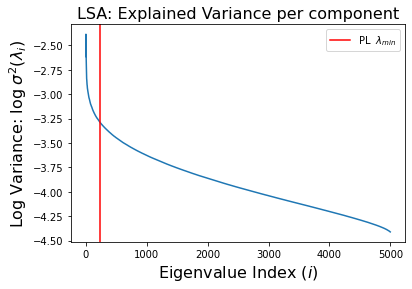

In [19]:
plt.plot(np.arange(5000),np.log10(svd_model.explained_variance_))
plt.title("LSA: Explained Variance per component")
plt.axvline(x=istart_tail, color='red', label=r"PL  $\lambda_{min}$")
plt.xlabel(r"Eigenvalue Index $(i)$")
plt.ylabel(r"Log Variance: $\log\;\sigma^{2}(\lambda_{i})$")
plt.legend()
if save:
  filename = "LSA_variance.png"
  filename = f"{results_dir}/{filename}"
  print(f"saving {filename}")
  plt.savefig(filename)
plt.show()


### Check for Correlation Traps

see: https://stackoverflow.com/questions/12230527/randomly-shuffle-a-sparse-matrix-in-python





In [20]:
W = X.todense()
N, M = W.shape[0], W.shape[1]       

if (N < M):
    N, M = W.shape[1], W.shape[0] 

W_shuf = W.flatten()
np.random.shuffle(W_shuf)
W_shuf = W_shuf.reshape([N, M])

In [21]:
svd_model.fit(W_shuf)
sv = svd_model.singular_values_
rand_evals = sv*sv

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


Text(0.5, 1.0, 'LSA ESD vs randomized ESD')

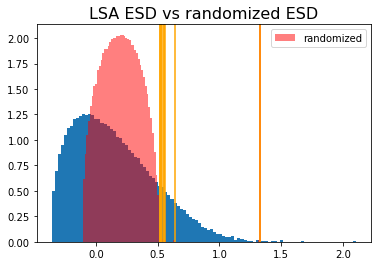

In [22]:
max_evals =  np.sort(np.log10(rand_evals))
for ev in max_evals[-10:]:
  plt.axvline(x=ev, color='orange')

plt.hist(np.log10(evals[evals>0.001]),bins=100, density=True);
plt.hist(np.log10(rand_evals[rand_evals>0.001]),bins=100, density=True, color='red', label='randomized', alpha=0.5);
plt.axvline(x=np.max(np.log10(rand_evals)), color='red')

plt.legend()
plt.title("LSA ESD vs randomized ESD")

In [23]:
break

SyntaxError: ignored

### MPFit the LSA Random Eigenvalues

And plot better!

Text(0, 0.5, 'Density')

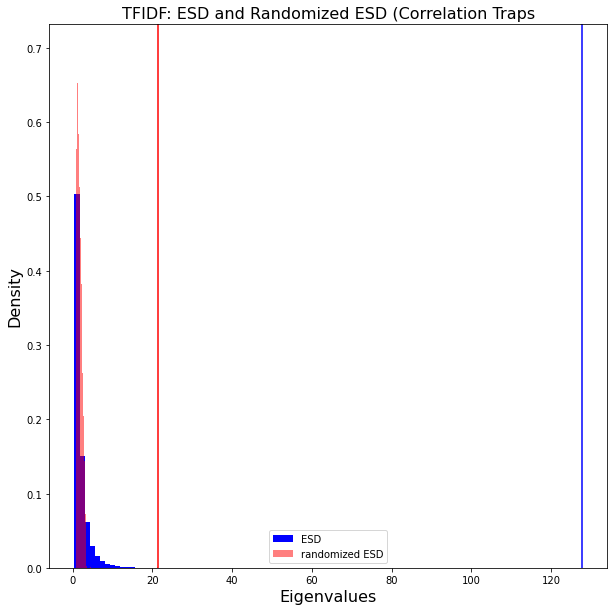

In [53]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

plt.hist((evals[evals>0.001]),bins=100, density=True, label='ESD', color='blue');
plt.axvline(x=np.max(evals), color='blue')



plt.hist((rand_evals[rand_evals>0.001]), bins=100, density=True, color='red',alpha=0.5, label='randomized ESD');
plt.axvline(x=np.max(rand_evals), color='red')
plt.legend()
plt.title("TFIDF: ESD and Randomized ESD (Correlation Traps")
plt.xlabel("Eigenvalues")
plt.ylabel("Density")

In [77]:
evals[:10]

array([127.67201081,  46.77798957,  32.22248379,  30.94234175,
        28.46101131,  26.89835367,  23.49393022,  22.97074294,
        21.88643125,  20.20783594])

In [92]:
max_evals =  np.sort((rand_evals))
Q = N/M
bulk_max = max_evals[-2]
TW_delta= 1/np.sqrt(Q)*np.power(bulk_max, 2/3)*np.power(M, -2/3)
bulk_max_TW = bulk_max + np.sqrt(TW_delta)
bulk_max_TW

4.430727059942976

Text(0, 0.5, 'Density')

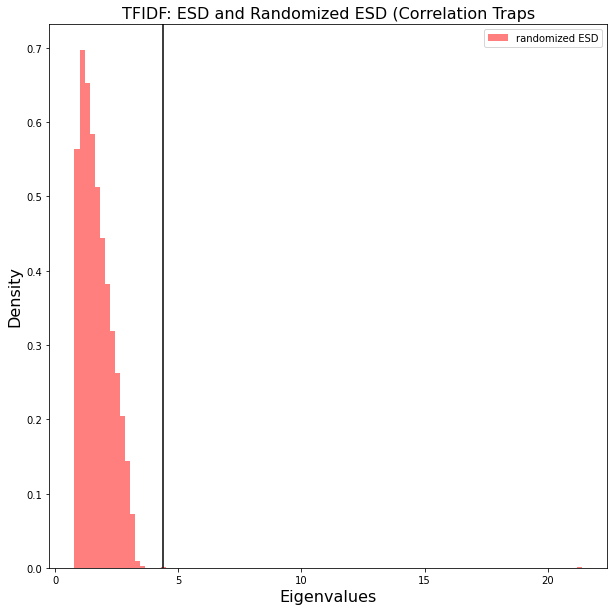

In [93]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)



plt.axvline(x=bulk_max, color='black')


plt.hist((rand_evals[rand_evals>0.001]), bins=100, density=True, color='red',alpha=0.5, label='randomized ESD');
plt.legend()
plt.title("TFIDF: ESD and Randomized ESD (Correlation Traps")
plt.xlabel("Eigenvalues")
plt.ylabel("Density")


bold text

In [97]:
!pip install weightwatcher

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 4.6 MB/s 
     |████████████████████████████████| 13.1 MB 30.4 MB/s 
  Created wheel for pyRMT: filename=pyRMT-0.1.0-py3-none-any.whl size=8677 sha256=89080a4cf1941c8f6617680b944e5c4606a84d1b7b18b5071acde4cc9c275c8e
  Stored in directory: /root/.cache/pip/wheels/8e/f9/d9/9bd86f1ed4b09d7764d699a3baf83e81395cf10722283a03b4
Successfully built pyRMT


In [98]:
import torch

class TinyModel(torch.nn.Module):

    def __init__(self, W):
        super(TinyModel, self).__init__()
        N, M = W.shape[0], W.shape[1]
        assert(N >= M)
        self.linear = torch.nn.Linear(N, M, bias=False)
        self.linear.weight.data = torch.from_numpy(W)

    def forward(self, x):
        x = self.linear(x)
        return x

In [99]:
lsa_model = TinyModel(X.todense().T)

INFO:weightwatcher:

python      version 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
numpy       version 1.21.6
tensforflow version 2.8.2
keras       version 2.8.0
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': True, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'fit': 'power_law', 'sparsify': True, 'min_evals': 0, 'max_evals': 21000, 'mp_fit': False, 'layers': []}
INFO:weightwatcher:Saving all images to ww-img


Assuming nested distributions


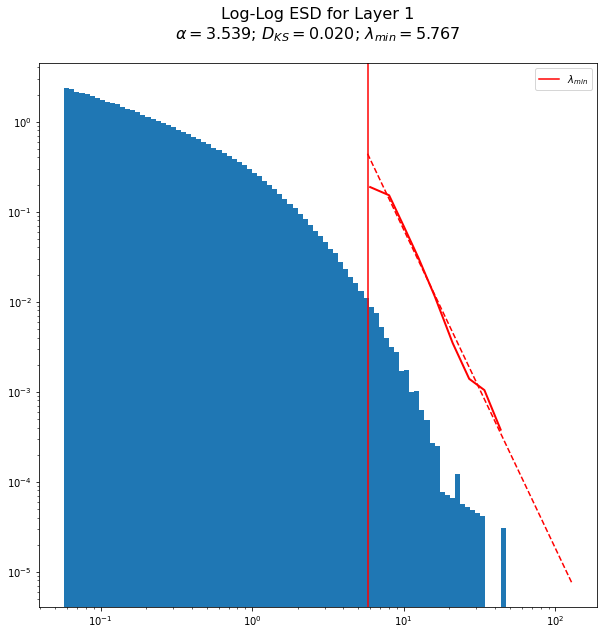

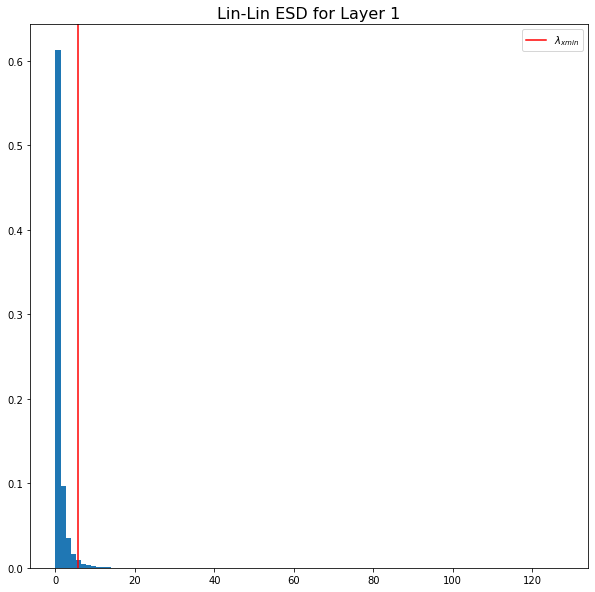

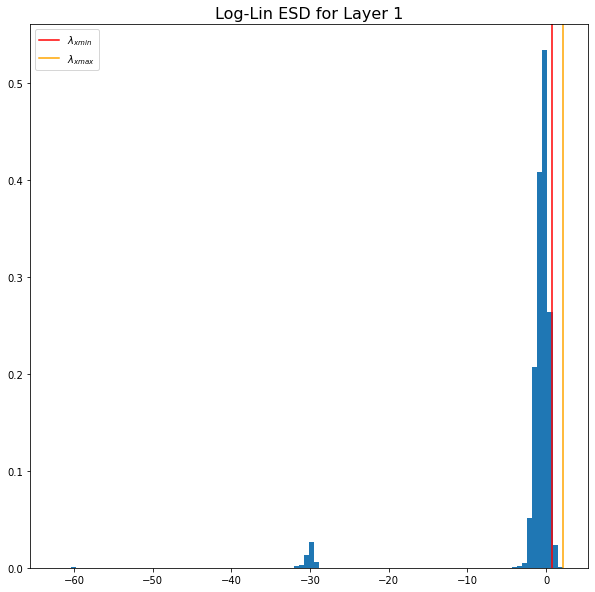

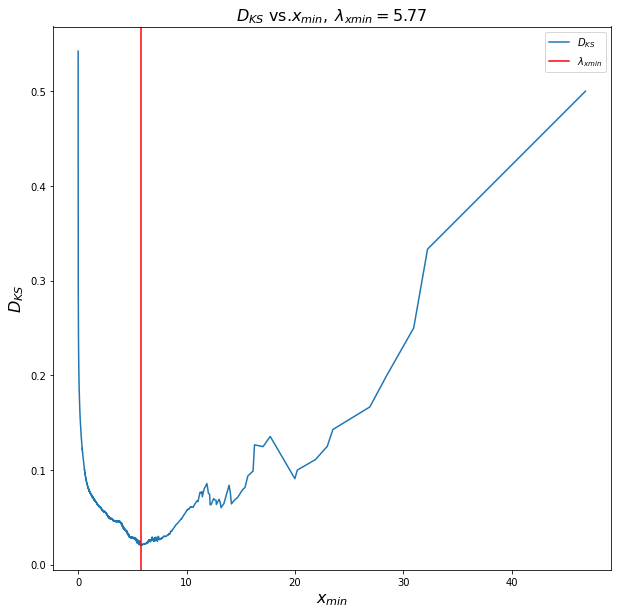

/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:905: ComplexWarning: Casting complex values to real discards the imaginary part
  db = np.array(np.diff(bin_edges), float)
/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:153: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


<Figure size 720x720 with 0 Axes>

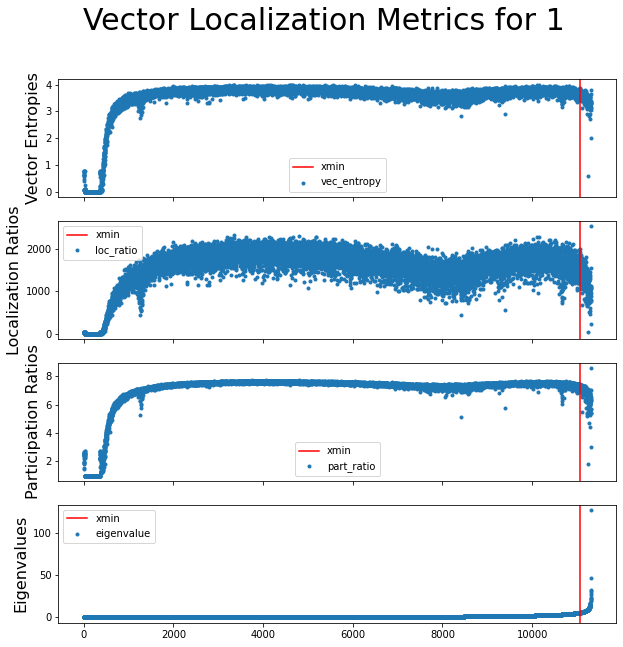

<Figure size 720x720 with 0 Axes>

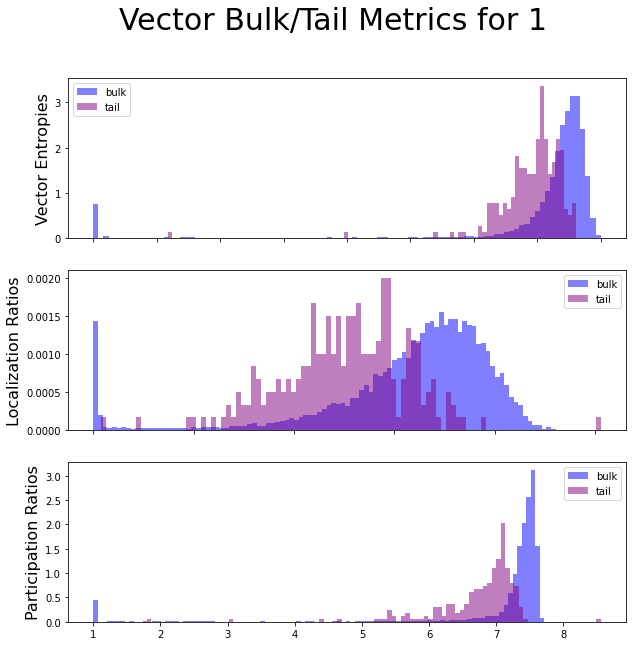

<Figure size 720x720 with 0 Axes>

In [100]:
import weightwatcher as ww

watcher = ww.WeightWatcher(lsa_model)
details = watcher.analyze(lsa_model, max_evals=21000, plot=True)

INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': True, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'fit': 'power_law', 'sparsify': True, 'min_evals': 0, 'max_evals': 21000, 'mp_fit': False, 'layers': []}
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': True, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'fit': 'power_law', 'sparsify': True, 'min_evals': 0, 'max_evals': 21000, 'mp_fit': False, 'layers': []}
INFO:

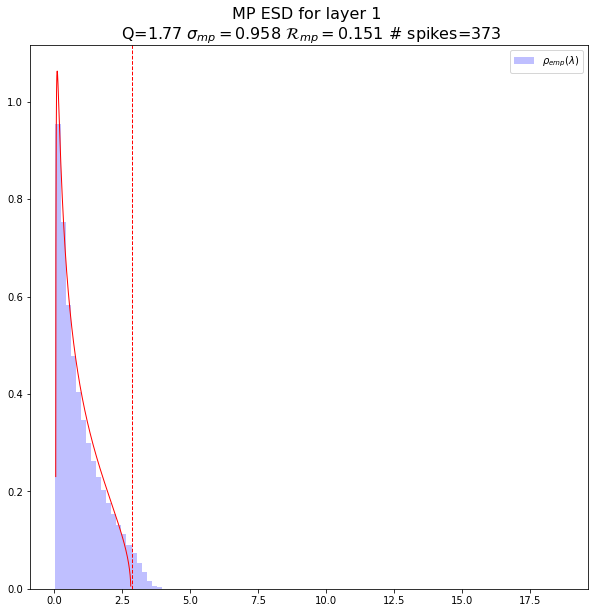

INFO:weightwatcher:apply truncated SVD on Layer 1 None, with nsmooth=-373,  keeping ncomp=10941 out of 11314. of the singular vectors
INFO:weightwatcher:LAYER TYPE  4 out of 4 8 64 


In [ ]:
lsa_sharp = watcher.SVDSharpness(lsa_model, plot=True)

In [ ]:
watcher = ww.WeightWatcher(lsa_sharp)
sharp_details = watcher.analyze(lsa_sharp, max_evals=21000, plot=True)

In [ ]:
details

In [ ]:
sharp_details